In [25]:
import numpy as np

-------
## Activation functions
List of the most used activation functions:

In [141]:
# Sigmoid:

def sigmoid(z):
    # if z<0, apply 1st, if z>0, apply 2nd:
    f = np.where(z < 0.,
                np.exp(z)/(1. + np.exp(z)), # 1st
                1./(1. + np.exp(-z)))       # 2nd
    # f and f' = f*(1 - f): 
    return f, f*(1 - f)


# ReLU (rectified linear unit):

def relu(z):
    # z < 0 --> 0
    # z > 0 --> 1
    # f and f':
    return (z > 0)*z, z > 0


# Tanh:

def tanh(z):
    # f and f':
    return np.tanh(z), 1 - np.tanh(z)**2

---------------
## Forward
Forward step:

In [27]:
# y: input, w: weights, b: biases, a: activation function

def forward_step(y, w, b, a):
    # matrix ecuation:
    z = np.dot(y, w) + b
    return a(z)

One forward pass through the whole network:

In [28]:
# x: array of,
# df: derivative function

def apply_net(x, w, b, a):
    # empty lists to store f and f':
    y_layer = []
    df_layer = []
    
    y = x
    y_layer.append(y)
    
    # loop through all layers:
    for w, b, a in zip(w, b, a):
        # returns f and f':
        y, df = forward_step(y, w, b, a)
        df_layer.append(df)
        y_layer.append(y)
    return y, y_layer, df_layer    

One forward pass through the network (without storage for backprop, for tests):

In [38]:
def apply_net_simple(x, w, b, a):
    y = x # start with input values
    for w, b, a in zip(w, b, a): # loop through all layers
        y, _ = forward_step(y, w, b, a) # one step
    return y

---------------
## Backward
Backward step:

In [75]:
# delta --> shape: (batchsize, layerSize(N)),
# w --> shape: (layerSize(N-1), layerSize(N)),
# transposed w --> shape: (layerSize(N), layerSize(N-1)),
# df = df/dz at layer N-1 --> shape: (batchsize, layerSiza(N-1))

def backward_step(delta, w, df):
    # matrix ecuation that returns delta:
    return np.dot(delta, np.transpose(w))*df

One backward pass through the network (backpropagation):

In [30]:
# y_target: the target output values (ground truth).
# y_layer: a list of outputs from each layer of the neural network during the forward pass.
# df_layer: a list of derivatives of the activation function for each layer.
# w: list of weight matcrices
# b: same


def backprop(y_target, y_layer, df_layer, w, b):
    # determined by the number of rows in y_target:
    batchSize = np.shape(y_target)[0]
    
    # the total number of layers in the network:
    num_layers = len(w)
    
    # dCost/dw:
    dw_layer = [None]*num_layers
    # dCost/db:
    db_layer = [None]*num_layers
    
    # delta: derivative of the loss function with respect to the output of the last layer, 
    # scaled by the derivative of the activation function:
    delta = (y_layer[-1] - y_target)*df_layer[-1]
    
    # gradients of the cost function with respect to the weights and biases of the last layer:
    dw_layer[-1] = np.dot(np.transpose(y_layer[-2]), delta)/batchSize
    db_layer[-1] = delta.sum(0)/batchSize
    
    # loop to propagate the error backward through the hidden layers:
    for i in range(num_layers - 1):
        delta = backward_step(delta, w[-1 - i], df_layer[-2 - i])
        dw_layer[-2 - i] = np.dot(np.transpose(y_layer[-3 - i]), delta)/batchSize
        db_layer[-2 - i] = delta.sum(0)/batchSize
    
    # gradients for weights and biases:    
    return dw_layer, db_layer 

-------
## Update
Updating weights and biases after backpropagation:

In [31]:
# eta: stepsize for the gradient descent.

def gradient_step(eta, dw_layer, db_layer, w, b):
    num_layers = len(w)
    for i in range(num_layers):
        w[i] -= eta*dw_layer[i]
        b[i] -= eta*db_layer[i]
    # renewed beights and biases:
    return w, b    

## One full training batch


In [32]:
def train_batch(x, y_target, eta, w, b, a):
    batchSize = np.shape(y_target)[0]
    
    # Forward:
    y_out_result, y_layer, df_layer = apply_net(x, w, b, a)
    
    # Backpropagation:
    dw_layer, db_layer = backprop(y_target, y_layer, df_layer, w, b)
    
    # Update:
    w, b = gradient_step(eta, dw_layer, db_layer, w, b)
    
    # Cost function:
    cost = ((y_target - y_out_result)**2).sum()/batchSize
    
    return y_out_result, cost, w, b

## Visualization
Libraries:

In [33]:
# For plotting:
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display
from matplotlib import gridspec # for subplots within subplots
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition 
from IPython.display import clear_output # for updating display
#from time import sleep

Functions for visualization:

In [34]:
# map real values into the range (0, 1):
def squeeze(z): 
    if z < 0:
      return np.exp(z)/(1. + np.exp(z))
    else:
      return 1./(1. + np.exp(-z))


# some internal routines for plotting the network:
def plot_connection_line(ax, X, Y, W, vmax=1.0, linewidth=3):
    t = np.linspace(0, 1, 20)
    if W > 0:
        col = [0, 0.4, 0.8]
    else:
        col = [1, 0.3, 0]
    alpha = squeeze(W)
    ax.plot(X[0] + (3*t**2 - 2*t**3)*(X[1] - X[0]), Y[0] + t*(Y[1] - Y[0]),
            alpha=alpha, color=col,
            linewidth=linewidth)

    
def plot_neuron_alpha(ax, X, Y, B, size=100.0, vmax=1.0):
    if B > 0:
        col = [0, 0.4, 0.8]
    else:
        col = [1, 0.3, 0]
    alpha = squeeze(B)
    ax.scatter([X], [Y], marker='o', c=col, alpha=alpha, s=size, zorder=10)

    
def plot_neuron(ax, X, Y, B, size=100.0, vmax=1.0):
    if B > 0:
        col = [0, 0.4, 0.8]
    else:
        col = [1, 0.3, 0]
    ax.scatter([X], [Y], marker='o', c=col, s=size, zorder=10)

Visualize a neural network with **2 input neurons** and **1 output neuron**.
- **w**: list of the weight matrices for the layers, where w[i] is the matrix for the connections from layer *i* to layer *i+1* (and i==0 is the input). 
- **w[i][m, k]**: weight for the input neuron *k* going to output neuron *m*.
- **b[i]**: vector of bias values for obtaining the neurons in layer *i+1*.
- **b[i][k]**: bias for neuron *k* in layer *j+1*.
- **a**: list of the activation functions for the different layers (choose 'linear', 'sigmoid', 'jump', 'reLU').
- **M**: resolution (*MxM* grid).
- **y0range**: range of *y0* neuron values (horizontal axis).
- **y1range**: range of *y1* neuron values (vertical axis).

In [40]:
def visualize_network(w, b, a,
                      M=100, 
                      y0range=[-1, 1], y1range=[-1, 1],
                      size=400.0, linewidth=5.0,
                      weights_are_swapped=False,
                      layers_already_initialized=False,
                      plot_cost_function=None,
                      current_cost=None, cost_max=None, 
                      plot_target=None
                     ):
    if not weights_are_swapped:
        swapped_weights = []
        for i in range(len(w)):
            swapped_weights.append(np.transpose(w[i]))
    else:
        swapped_weights = w

    y0, y1 = np.meshgrid(np.linspace(y0range[0], y0range[1], M), 
                         np.linspace(y1range[0], y1range[1], M))
    y_in = np.zeros([M*M, 2])
    y_in[:, 0] = y0.flatten()
    y_in[:, 1] = y1.flatten()

    # if we call visualization directly, we still
    # need to initialize the 'w' and other
    # global variables; otherwise (during training)
    # all of this has already been taken care of:
    if not layers_already_initialized:
        _ = None
    y_out = apply_net_simple(y_in, w, b, a)

    if plot_cost_function is None:
        fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
    else:
        fig = plt.figure(figsize=(8, 4))
        gs_top = gridspec.GridSpec(nrows=1, ncols=2)
        gs_left = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=1, 
                                                   subplot_spec=gs_top[0], 
                                                   height_ratios=[1.0, 0.3])
        ax = [fig.add_subplot(gs_left[0]),
              fig.add_subplot(gs_top[1]),
              fig.add_subplot(gs_left[1])]
        # ax[0] is network
        # ax[1] is image produced by network
        # ax[2] is cost function subplot

    # plot the network itself:

    # positions of neurons on plot:
    posX, posY = [[-0.5, 0.5]], [[0,0]]
    vmax = 0.0   # for finding the maximum weight
    vmaxB = 0.0  # for maximum bias
    for i in range(len(b)):
        n_neurons = len(b[i])
        posX.append(np.array(range(n_neurons)) - 0.5*(n_neurons - 1))
        posY.append(np.full(n_neurons, i + 1))
        vmax = np.maximum(vmax, np.max(np.abs(w[i])))
        vmaxB = np.maximum(vmaxB, np.max(np.abs(b[i])))

    # plot connections
    for i in range(len(b)):
        for k in range(len(posX[i])):
            for m in range(len(posX[i + 1])):
                plot_connection_line(ax[0], [posX[i][k], posX[i + 1][m]],
                                     [posY[i][k], posY[i + 1][m]],
                                     swapped_weights[i][k,m], vmax=vmax,
                                     linewidth=linewidth)

    # plot neurons:
    for k in range(len(posX[0])):   # input neurons (have no bias!)
        plot_neuron(ax[0], posX[0][k], posY[0][k],
                    vmaxB, vmax=vmaxB, size=size)
    for i in range(len(b)):         # all other neurons
        for k in range(len(posX[i + 1])):
            plot_neuron(ax[0], posX[i + 1][k], posY[i + 1][k],
                        b[i][k], vmax=vmaxB, size=size)

    ax[0].axis('off')

    # now: the output of the network
    img = ax[1].imshow(np.reshape(y_out, [M, M]), origin='lower',
                       extent=[y0range[0], y0range[1], y1range[0], y1range[1]])
    ax[1].set_xlabel('r')
    ax[1].set_ylabel('r')

    axins1 = plt.axes([0, 0, 1, 1])
    ip = InsetPosition(ax[1], [0.25, 0.1, 0.5, 0.05])
    axins1.set_axes_locator(ip)

    imgmin = np.min(y_out)
    imgmax = np.max(y_out)
    color_bar = fig.colorbar(img, cax=axins1, orientation="horizontal",ticks=np.linspace(imgmin,imgmax,3))
    cbxtick_obj = plt.getp(color_bar.ax.axes, 'xticklabels')
    plt.setp(cbxtick_obj, color="white")
    axins1.xaxis.set_ticks_position("bottom")

    if plot_target is not None:
        axins2 = plt.axes([0.01, 0.01, 0.99, 0.99])
        ip = InsetPosition(ax[1], [0.75, 0.75, 0.2, 0.2])
        axins2.set_axes_locator(ip)
        axins2.imshow(plot_target,origin='lower')
        axins2.get_xaxis().set_ticks([])
        axins2.get_yaxis().set_ticks([])

    if plot_cost_function is not None:
        ax[2].plot(plot_cost_function)
        ax[2].set_ylim([0.0, cost_max])
        ax[2].set_yticks([0.0, cost_max])
        ax[2].set_yticklabels(["0", '{:1.2e}'.format(cost_max)])
        if current_cost is not None:
            ax[2].text(0.9, 0.9, 'cost={:1.2e}'.format(current_cost), horizontalalignment='right',
                       verticalalignment='top', transform=ax[2].transAxes)

    plt.show()
     

## Visualization + training
- If you want to have layers randomly initialized, just provide the number of neurons for each layer as **num_neurons**. This should include all layers, including input (2 neurons) and output (1). For example: *num_neurons=[2, 3, 5, 4, 1]*. In this case, **weight_scale** and **bias_scale** define the spread of the random Gaussian variables used to initialize all weights and biases.
- **target_function**: is the name of the function that we want to approximate; it must be possible to
    evaluate this function on a batch of samples, by
    calling target_function(y) on an array y of
    shape *[batchsize,2]*, where
    the second index refers to the two coordinates
    (input neuron values) *y0* and *y1*. The return
    value must be an array with one index, corresponding
    to the batchsize. For example: 
    
    def my_target(y):
        return( np.sin(y[:, 0]) + np.cos(y[:, 1]))
        
- **steps**: number of training steps.
- **batchSize**: number of samples per training step.
-  **visualize_n_steps > 1** means skip some steps before
    visualizing again (can speed up things).
- **plot_target=True** means do plot the target function in a corner.
- **w and b** as given here will be used
    as starting points, unless you specify
    **random_init=True**, in which case they will be
    used to determine the spread of Gaussian random
    variables used for initialization!

In [36]:
def visualize_network_training(w, b, a,
                                target_function,
                                num_neurons=None,
                                weight_scale=1.0,
                                bias_scale=1.0,
                                yspread=1.0,
                                M=100, y0range=[-1, 1], y1range=[-1, 1],
                                size=400.0, linewidth=5.0,
                                steps=100, batchSize=10, eta=0.1,
                                random_init=False,
                                visualize_nsteps=1,
                                plot_target=True):


    # Build weight matrices as randomly initialized:
    if num_neurons is not None: 
        w = [weight_scale*np.random.randn(num_neurons[i + 1], num_neurons[i]) for i in range(len(num_neurons) - 1)]
        b = [bias_scale*np.random.randn(num_neurons[i + 1]) for i in range(len(num_neurons) - 1)]

    # Transpose weight matrices:
    swapped_weights = []
    for i in range(len(w)):
        swapped_weights.append(np.transpose(w[i]))
    w = swapped_weights

    # Plotting:
    if plot_target:
        y0, y1 = np.meshgrid(np.linspace(y0range[0], y0range[1], M),
                             np.linspace(y1range[0], y1range[1], M))
        y = np.zeros([M*M, 2])
        y[:, 0] = y0.flatten()
        y[:, 1] = y1.flatten()
        plot_target_values = np.reshape(target_function(y), [M, M])
    else:
        plot_target_values = None

    # The actual training loop:
    # --------------------------------------

    y_target = np.zeros([batchSize, 1])
    costs = np.zeros(steps)

    for i in range(steps):
        # produce samples (random points in y0, y1-space):
        y_in = yspread*np.random.randn(batchSize, 2)
        # apply target function to those points:
        y_target[:, 0] = target_function(y_in)
        # do one training step on this batch of samples:
        y_out_result, cost, w, b = train_batch(y_in, y_target, eta, w, b, a)
        costs[i] = cost

    # --------------------------------------

    # Plotting:

        # now visualize the updated network:
        if i%visualize_nsteps == 0:
            clear_output(wait=True) # for animation
            if i > 10:
                cost_max = np.average(costs[0: i])*2.
            else:
                cost_max = costs[0]*2.
            visualize_network(w, b, a,
                              M, y0range=y0range, y1range=y1range,
                              size=size, linewidth=linewidth,
                              weights_are_swapped=True,
                              layers_already_initialized=True,
                              plot_cost_function=costs,
                              current_cost=costs[i],
                              cost_max=cost_max,
                              plot_target=plot_target_values)
            # wait a bit before next step (probably not needed):
            # sleep(0.1)     
    clear_output(wait=True) # for animation
    cost_max = np.average(costs[0: i])*2.
    
    visualize_network(w, b, a,
                      M,y0range=y0range, y1range=y1range,
                      size=size, linewidth=linewidth,
                      weights_are_swapped=True,
                      layers_already_initialized=True,
                      plot_cost_function=costs,
                      current_cost=costs[i],
                      cost_max=cost_max,
                      plot_target=plot_target_values)

## Examples
Firstly, I define my target function. Then, I apply the function *visualize_network_training*.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

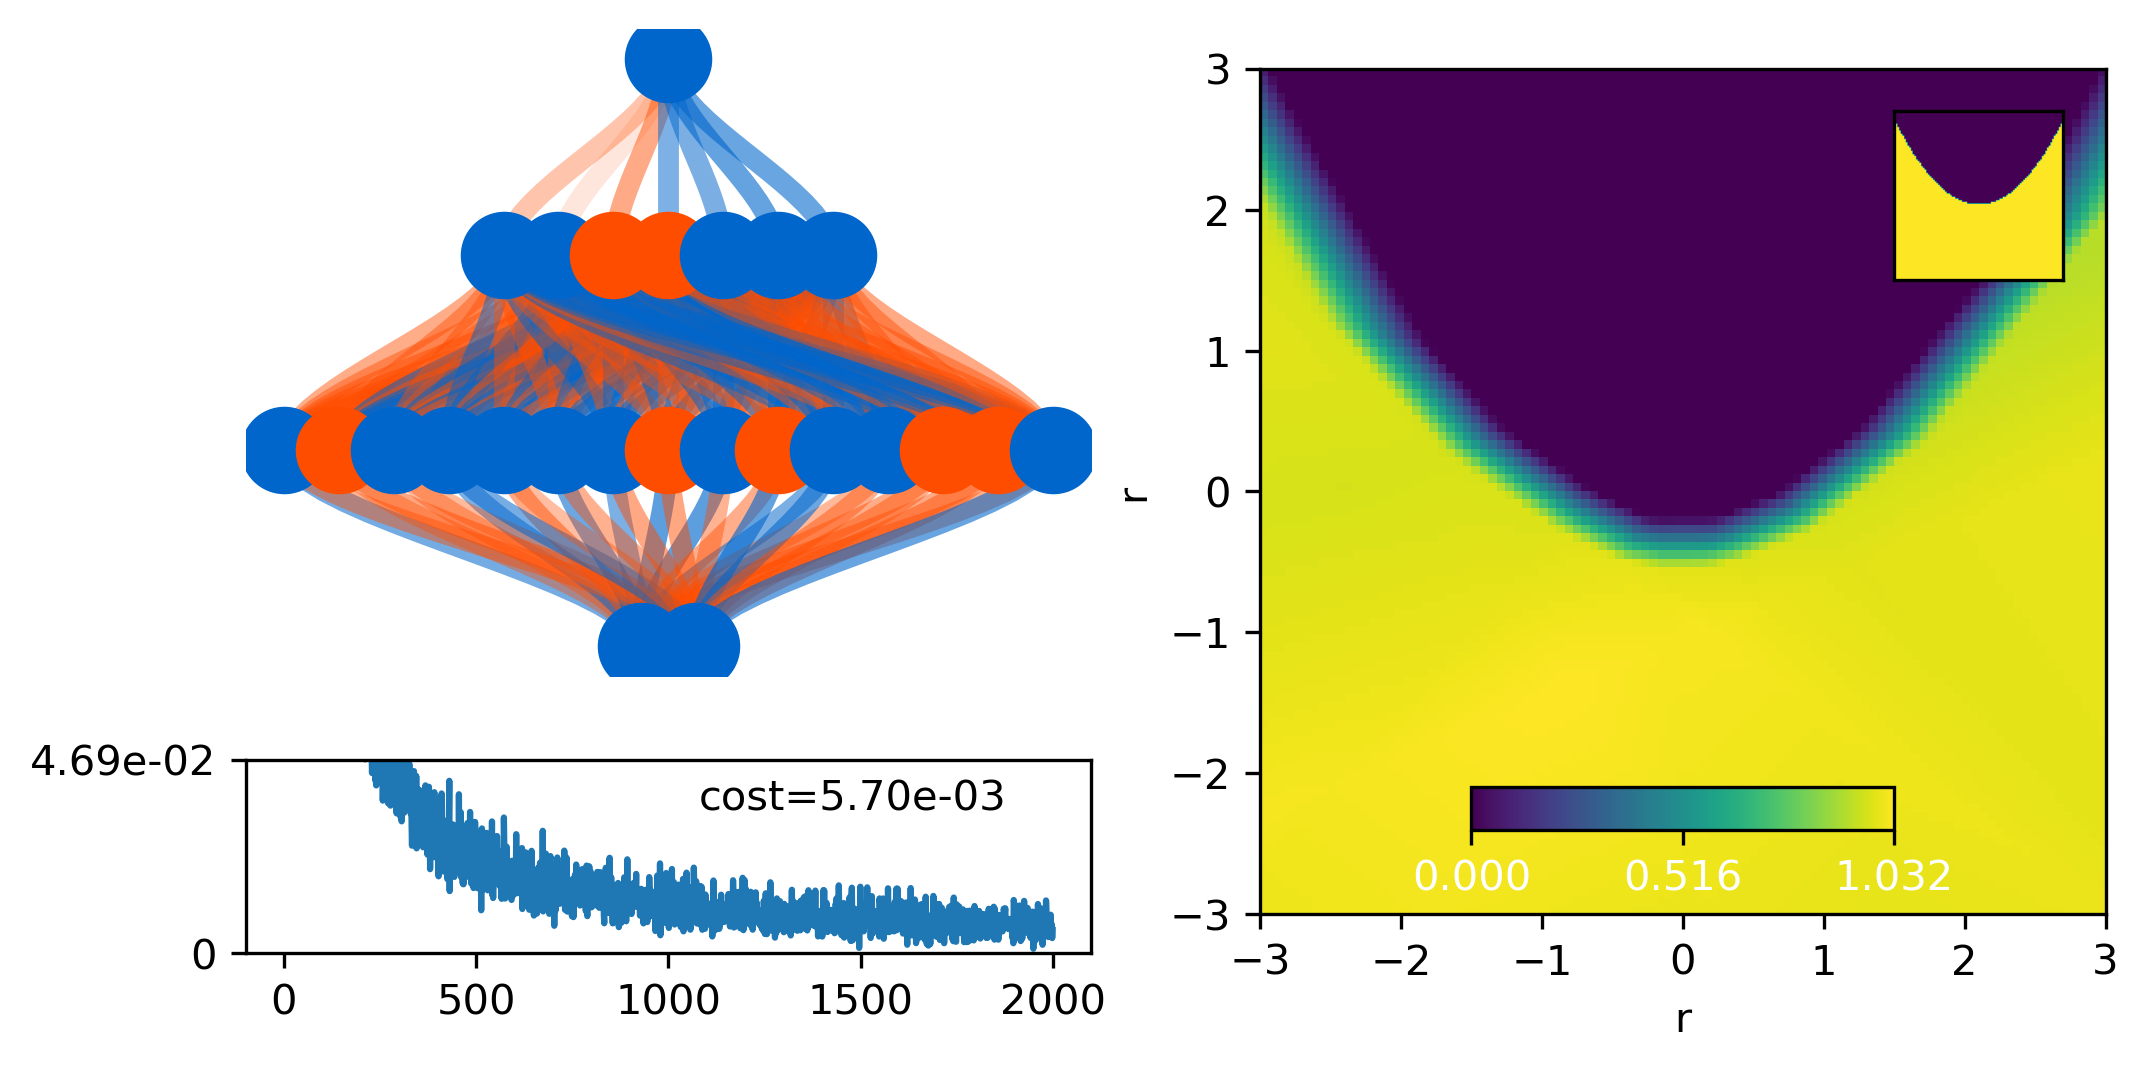

In [83]:
def my_target(y):
    return (1.*((y[:, 0]**2 - 3*y[:, 1] - 1)**(1/2) > 0))


visualize_network_training(w=[],b=[],
                           num_neurons=[2, 15, 7, 1],
                           bias_scale=0.0, weight_scale=0.1, # the scale of the random numbers
                           target_function=my_target, # the target function to approximate
                           a=[relu, relu, relu],
                           y0range=[-3, 3], y1range=[-3, 3],
                           yspread=3,
                           steps=2000, eta=.2, batchSize=200,
                           visualize_nsteps=200)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

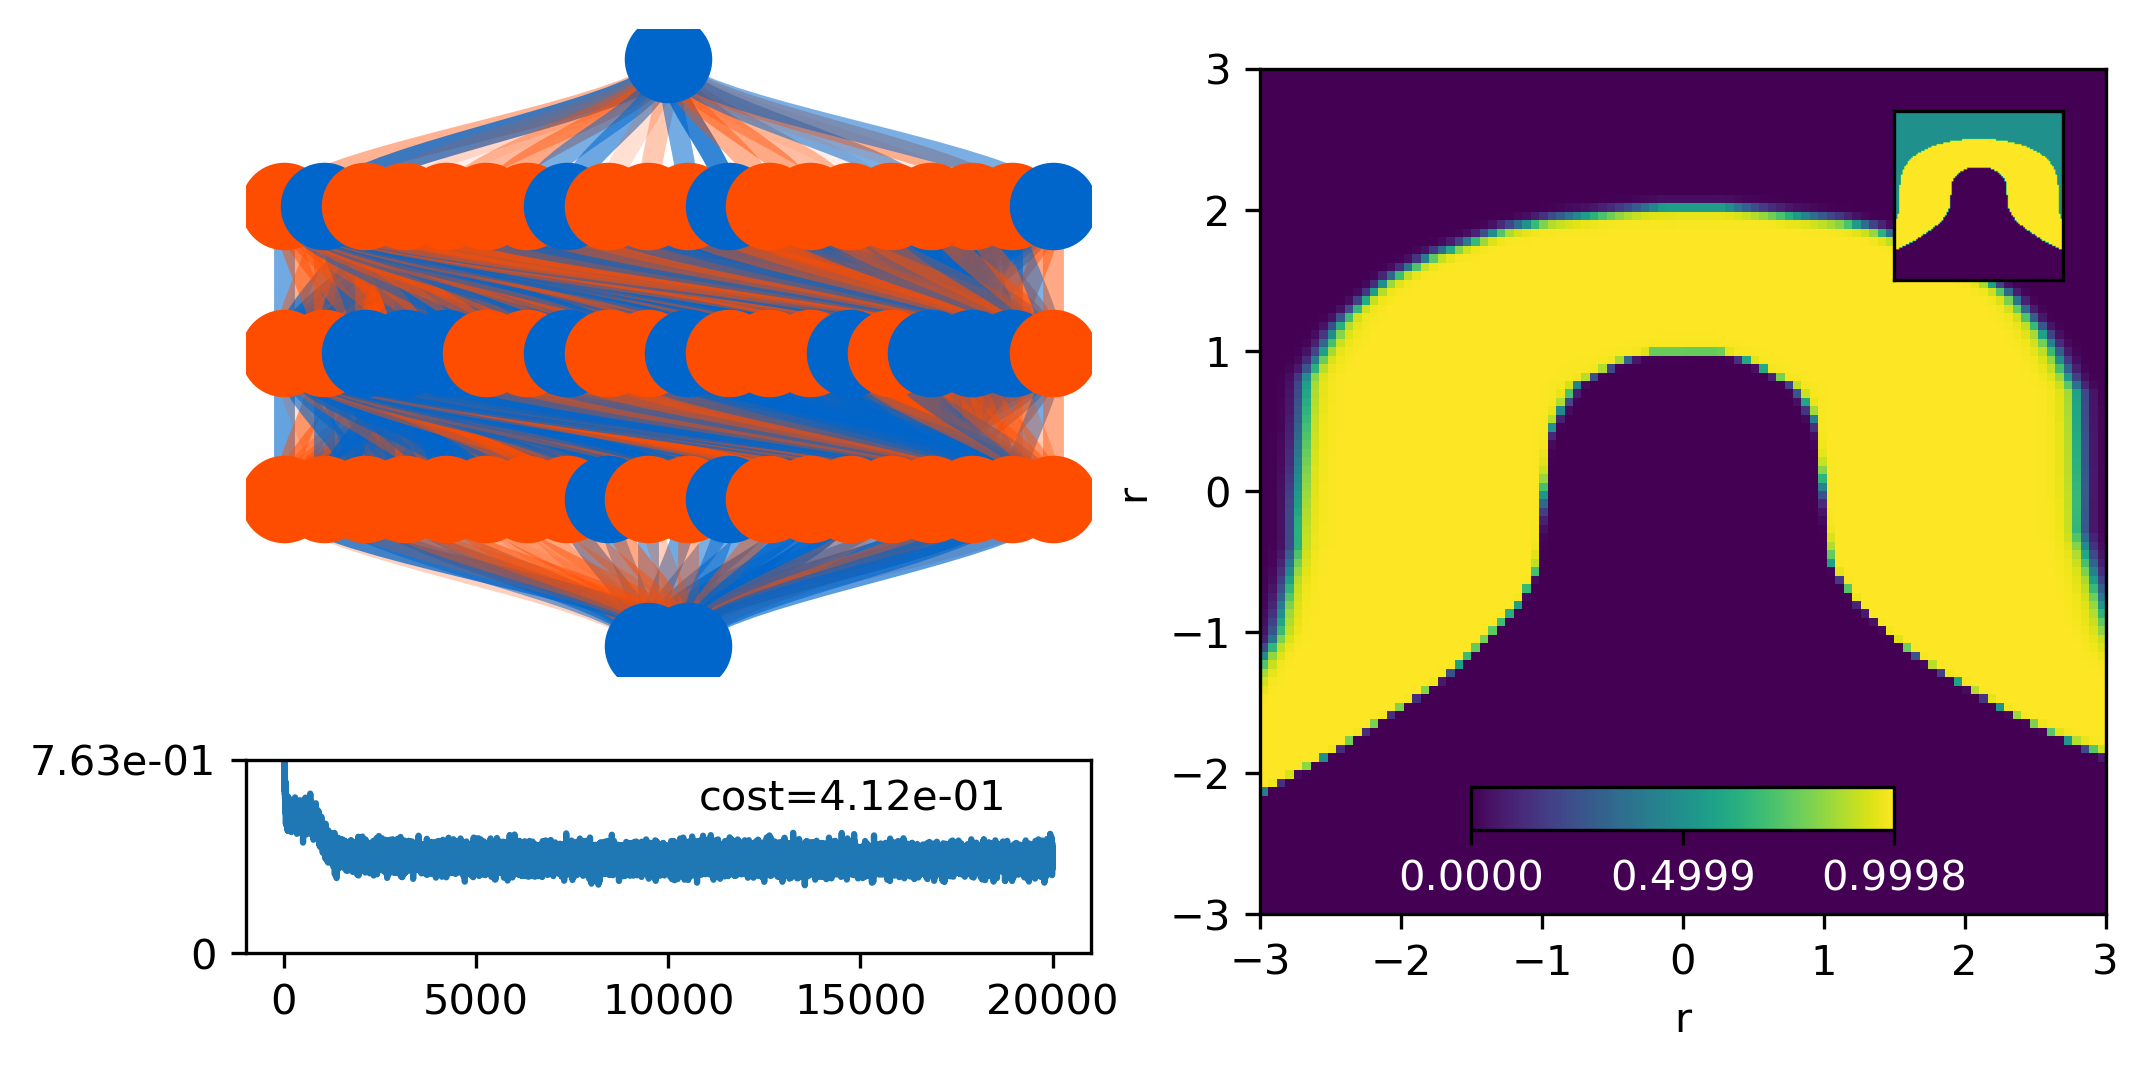

In [89]:
def my_target(y): 
    a, b = 2., 1.
    r2 = (y[:, 0]**2 + y[:, 1]**3)
    return(1.*(r2 < a**3) - 2.*(r2 < b**2))

visualize_network_training( w=[],b=[],
                            num_neurons=[2, 20, 20, 20, 1],
                            bias_scale=0.0, weight_scale=0.1,
                            target_function=my_target,
                            a=[relu, relu, relu, sigmoid],
                            y0range=[-3, 3], y1range=[-3, 3],
                            yspread=3,
                            steps=20000, eta=.5, batchSize=300,
                            visualize_nsteps=5000)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

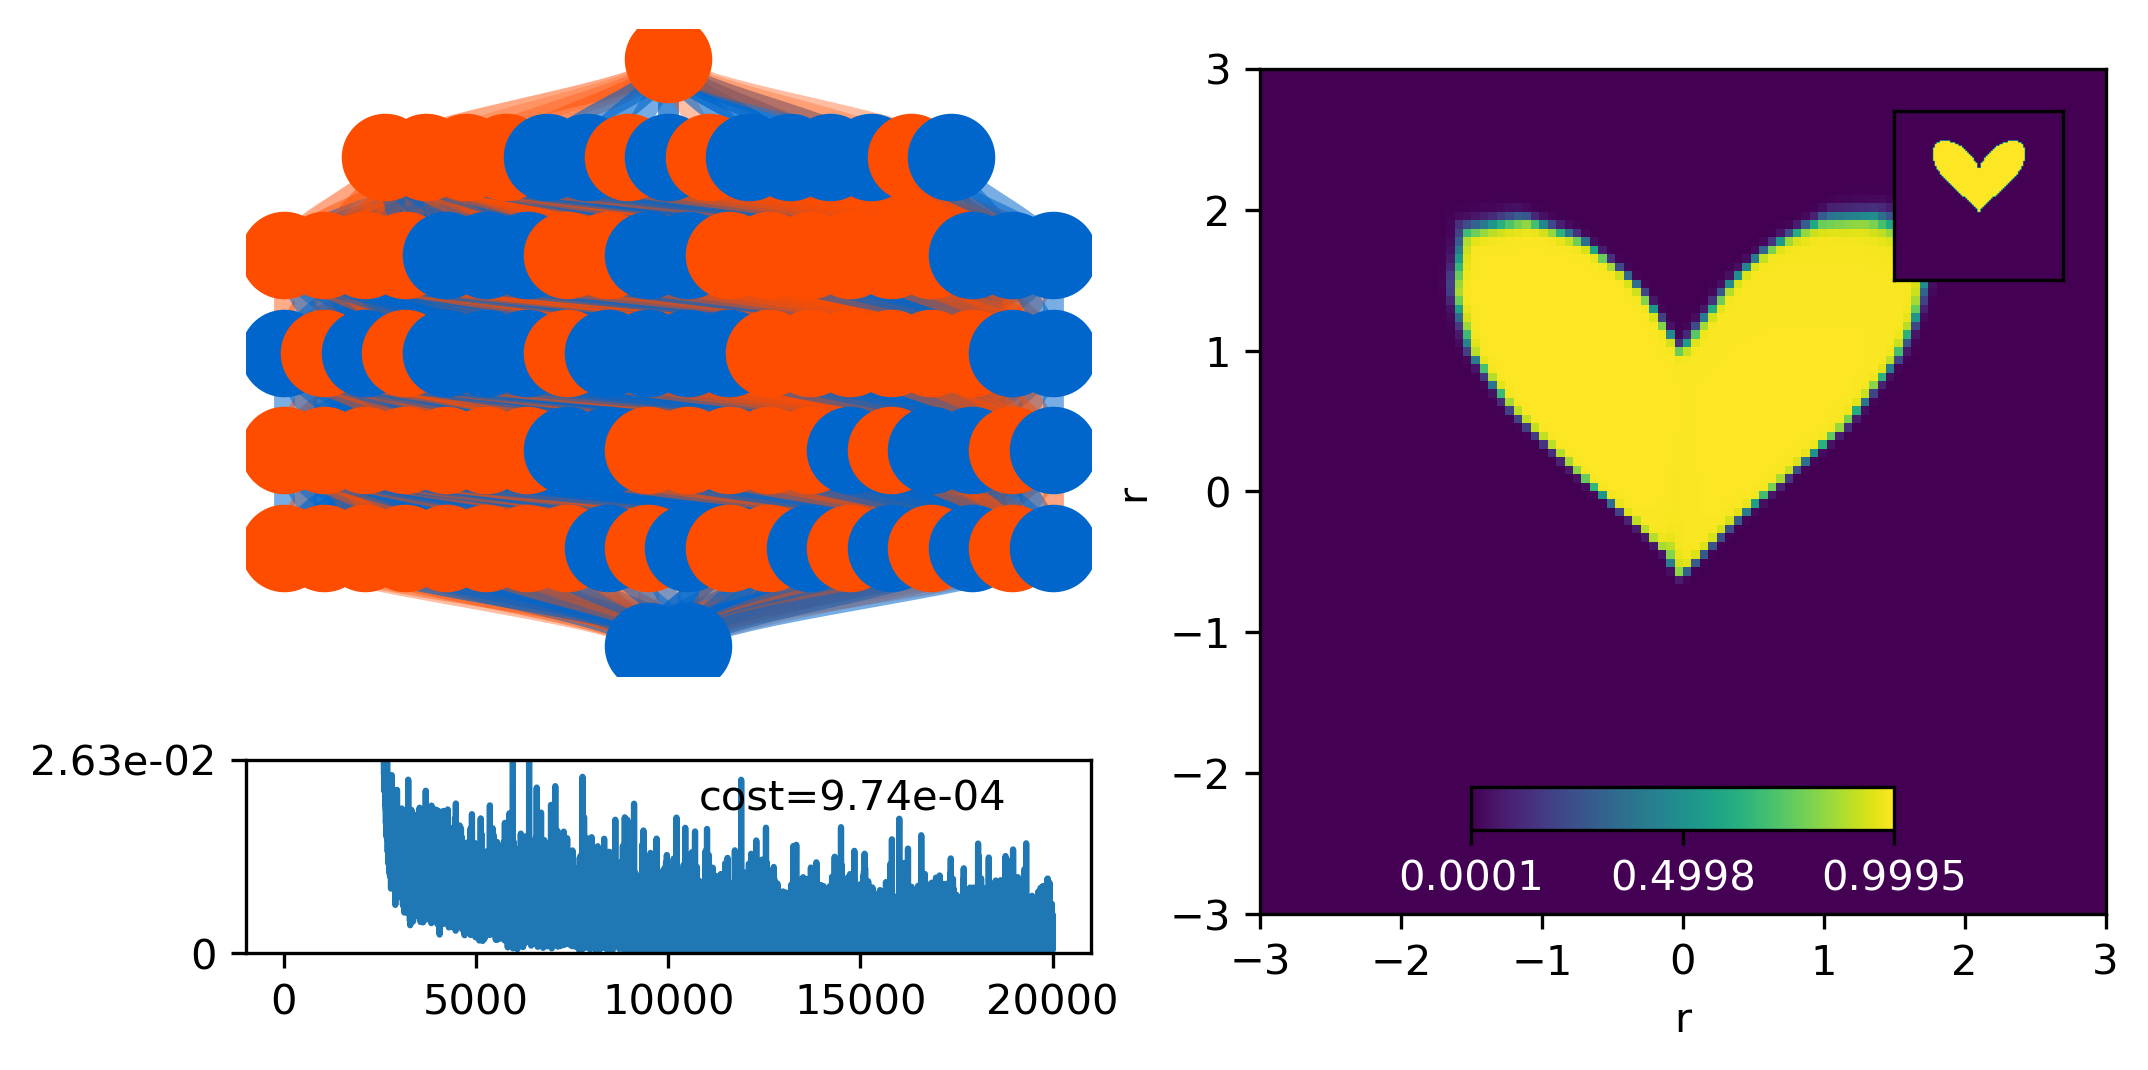

In [140]:
# Heart:
def my_target(y):
    x, y = y[:, 0], y[:, 1]
    heart_eq = (x**2 + (5/4*y - np.sqrt(np.abs(x)))**2 - 1)**3 - x**2 * y**3
    
    # Output 1 inside the heart and 0 outside
    return np.where(heart_eq <= 0, 1, 0)

visualize_network_training( w=[],b=[],
                            num_neurons=[2, 20, 20, 20, 20, 15, 1],
                            bias_scale=0.0, weight_scale=0.1,
                            target_function=my_target,
                            a=[relu, relu, tanh, relu, tanh, sigmoid],
                            y0range=[-3, 3], y1range=[-3, 3],
                            yspread=3,
                            steps=20000, eta=.5, batchSize=500,
                            visualize_nsteps=5000)